### MPI setup
* `ipyparallel` is used to start an IPython kernel 
* `mpi4py` is used like in regular `.py` scripts to handle MPI communication

In [4]:
import ipyparallel as ipp
cluster = ipp.Cluster(engines="mpi", n=4).start_and_connect_sync()

Starting 4 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/4 [00:00<?, ?engine/s]

In [5]:
%%px
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()
print(f"Process {rank} of {size} is running")

[stdout:0] Process 0 of 4 is running


[stdout:2] Process 2 of 4 is running


[stdout:1] Process 1 of 4 is running


[stdout:3] Process 3 of 4 is running


Import packages as usual, now starting with the magic `%%px` to execute it in all MPI ranks

In [6]:
%%px
import os
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from wakis import SolverFIT3D
from wakis import GridFIT3D 
from wakis import WakeSolver

from tqdm import tqdm

### Domain setup:
* __Capital variables__ are used as a convention to designate GLOBAL domain quantities: `NZ`, `ZMIN`, `ZMAX`
* __Lower case variables__ `Nz`, `zmin`, `zmax` will be associated to MPI subdomains and will be different for each `rank`. 
    * This quantities will be computed inside `GridFIT3D` when `use_mpi=True`

In [7]:
%%px
# ---------- Domain setup ---------
# Geometry & Materials
solid_1 = 'notebooks/data/002_vacuum_cavity.stl'
solid_2 = 'notebooks/data/002_lossymetal_shell.stl'

stl_solids = {'cavity': solid_1, 
              'shell': solid_2
              }

stl_materials = {'cavity': 'vacuum', 
                 'shell': [30, 1.0, 30] #[eps_r, mu_r, sigma[S/m]]
                 }

# Extract domain bounds from geometry
solids = pv.read(solid_1) + pv.read(solid_2)
xmin, xmax, ymin, ymax, ZMIN, ZMAX = solids.bounds

# Number of mesh cells
Nx = 80
Ny = 80
NZ = 141

In [8]:
%%px
grid = GridFIT3D(xmin, xmax, ymin, ymax, ZMIN, ZMAX, 
                Nx, Ny, NZ, 
                use_mpi = True,
                stl_solids=stl_solids, 
                stl_materials=stl_materials,
                stl_scale=1.0,
                stl_rotate=[0,0,0],
                stl_translate=[0,0,0],
                verbose=1)
                
print(f"Process {rank}: Handling Z range {grid.zmin} to {grid.zmax} with {grid.Nz} cells")

[stdout:0] MPI initialized for 0 of 4
Generating grid...
Importing stl solids...
Process 0: Handling Z range -0.25 to -0.044285711220332556 with 36 cells


[stdout:3] MPI initialized for 3 of 4
Generating grid...
Importing stl solids...
Process 3: Handling Z range 0.3442857231412615 to 0.550000011920929 with 36 cells


%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

[stdout:1] MPI initialized for 1 of 4
Generating grid...
Importing stl solids...
Process 1: Handling Z range -0.055714282819202966 to 0.15571429175989968 with 37 cells


[stdout:2] MPI initialized for 2 of 4
Generating grid...
Importing stl solids...
Process 2: Handling Z range 0.14428572016102928 to 0.35571429474013194 with 37 cells


### Solver definition
* We define our solver as for a non-MPI simulation, just passing `use_mpi=True`

In [9]:
%%px
# boundary conditions
bc_low=['pec', 'pec', 'pec']
bc_high=['pec', 'pec', 'pec']

# Solver setup
solver = SolverFIT3D(grid,
                    bc_low=bc_low, 
                    bc_high=bc_high, 
                    use_stl=True,
                    use_mpi=True, 
                    bg='pec' # Background material
                    )

# image folder creation
img_folder = 'notebooks/005_img/'
if not os.path.exists(img_folder): 
    os.mkdir(img_folder)

[stdout:1] Assembling operator matrices...
Applying boundary conditions...
Adding material tensors...
Calculating maximal stable timestep...
Pre-computing...
Total initialization time: 0.7666559219360352 s


[stdout:2] Assembling operator matrices...
Applying boundary conditions...
Adding material tensors...
Calculating maximal stable timestep...
Pre-computing...
Total initialization time: 0.7583250999450684 s


[stdout:0] Assembling operator matrices...
Applying boundary conditions...
Adding material tensors...
Calculating maximal stable timestep...
Pre-computing...
Total initialization time: 0.6795504093170166 s


[stdout:3] Assembling operator matrices...
Applying boundary conditions...
Adding material tensors...
Calculating maximal stable timestep...
Pre-computing...
Total initialization time: 0.6086428165435791 s


We can visualize our conductivity tensor $\sigma$ for each rank subdomain:

[output:0]

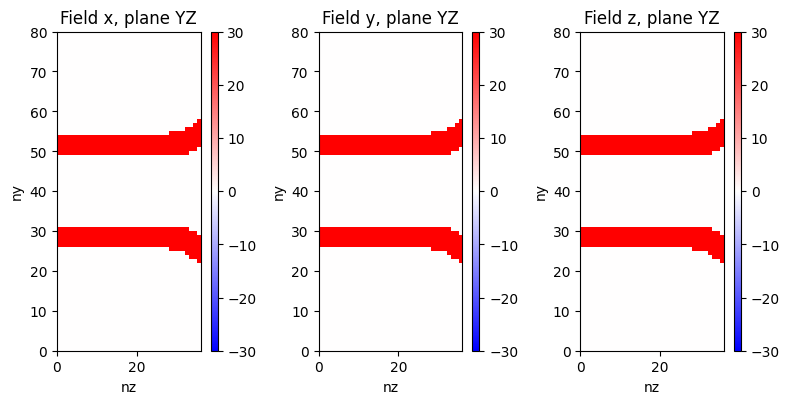

[output:1]

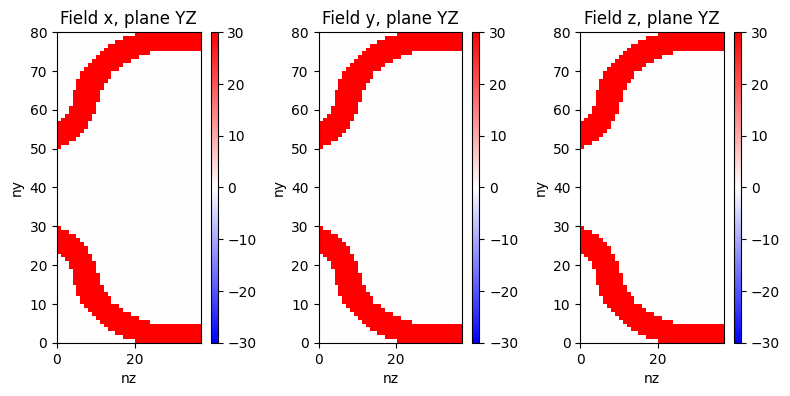

[output:3]

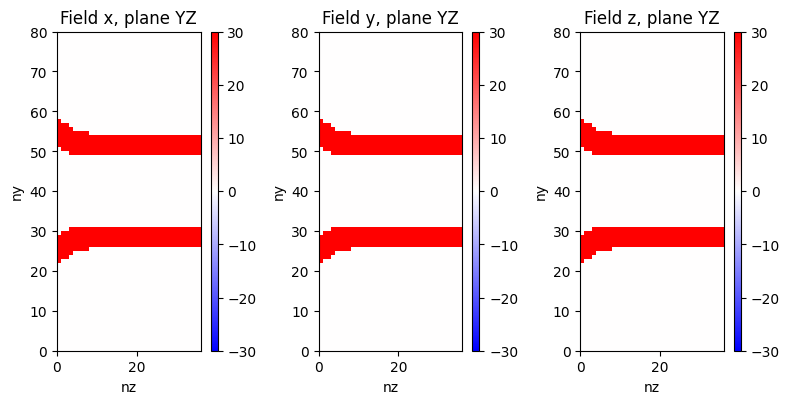

[output:2]

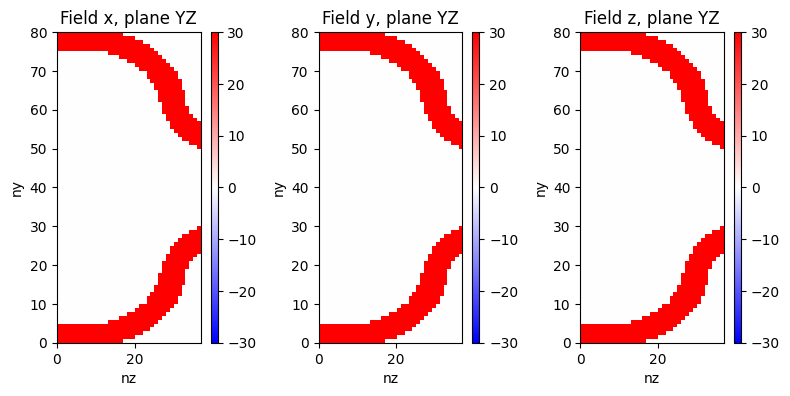

In [10]:
%%px
for n in range(size):
    if rank==n:
        solver.sigma.inspect()

We generate our beam source as per a non-MPI simulation:

In [11]:
%%px
# ------------ Beam source & Wake ----------------
# Beam parameters
sigmaz = 10e-2      #[m] -> 2 GHz
q = 1e-9            #[C]
beta = 1.0          # beam beta 
xs = 0.             # x source position [m]
ys = 0.             # y source position [m]
xt = 0.             # x test position [m]
yt = 0.             # y test position [m]
# [DEFAULT] tinj = 8.53*sigmaz/c_light  # injection time offset [s] 

# Simualtion
wakelength = 10. # [m]
add_space = 10   # no. cells to skip from boundaries - removes BC artifacts

from wakis.sources import Beam
from scipy.constants import c
beam = Beam(q=q, sigmaz=sigmaz, beta=beta,
            xsource=xs, ysource=ys, ti=3*sigmaz/c)

### Time loop
* We can run our simulation as usual, only changing the field advance to `mpi_one_step()`

In [12]:
%%px
n = 0
solver.reset_fields()

plot_inspect = False
plot_2D = True
plot_1D = False

In [13]:
%%px
Nt = 3000
for n in tqdm(range(Nt)):
    
    beam.update(solver, n*solver.dt)

    solver.mpi_one_step()
    
    # Plot inspect every 20 timesteps
    if n%20 == 0 and plot_inspect:
        E = solver.mpi_gather_asField('E')
        if rank == 0:
            fig, ax = E.inspect(figsize=[20,6], plane='YZ', show=False, handles=True)
            fig.savefig(img_folder+'Einspect_'+str(n).zfill(4)+'.png')
            plt.close(fig)

    # Plot E abs in 2D every 20 timesteps
    if n%20 == 0 and plot_2D:
        solver.plot2D(field='E', component='Abs', 
                    plane='YZ', pos=0.5, 
                    cmap='rainbow', vmin=0, vmax=500., interpolation='hanning',
                    off_screen=True, title=img_folder+'Ez2d', n=n)

    # Plot E z in 1D at diferent transverse positions `pos` every 20 timesteps
    if n%20 == 0 and plot_1D:
        solver.plot1D(field='E', component='z', 
              line='z', pos=[0.45, 0.5, 0.55], ylim=(-800, 800),
              xscale='linear', yscale='linear',
              off_screen=True, title=img_folder+'Ez1d', n=n)

[stderr:0] 100%|██████████| 3000/3000 [02:12<00:00, 22.67it/s]


[stderr:1] 100%|██████████| 3000/3000 [02:12<00:00, 22.67it/s]


[stderr:3] 100%|██████████| 3000/3000 [02:12<00:00, 22.67it/s]


[stderr:2] 100%|██████████| 3000/3000 [02:12<00:00, 22.67it/s]


%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

### Post-processing
* We can generate a `GIF` animation from a notebook cell and display it in the notebook:

In [14]:
!convert -delay 10 -loop 0 notebooks/005_img/E*.png notebooks/005_img/005_E.gif
!rm notebooks/005_img/E*.png

In [15]:
from IPython.display import HTML
HTML('<img src="005_img/005_E.gif">')

* We can also plot the last timestep's fields `E`, `H` or `J`

[output:0]

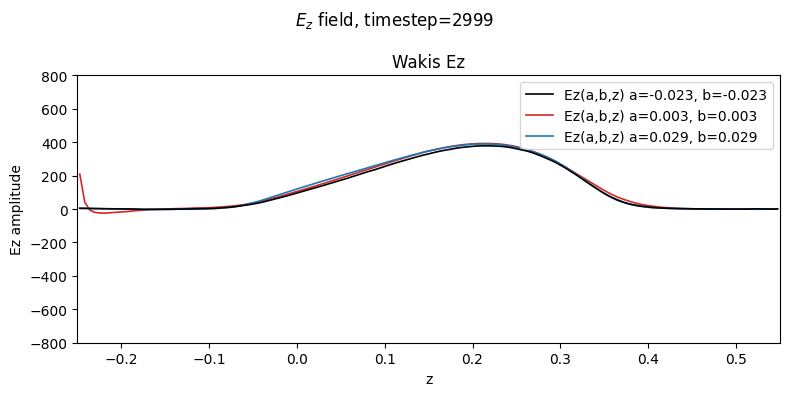

In [19]:
%%px
solver.plot1D(field='E', component='z', 
              line='z', pos=[0.45, 0.5, 0.55], ylim=(-800, 800),
              xscale='linear', yscale='linear',
              off_screen=False, title=img_folder+'Ez1d', n=n)

[output:0]

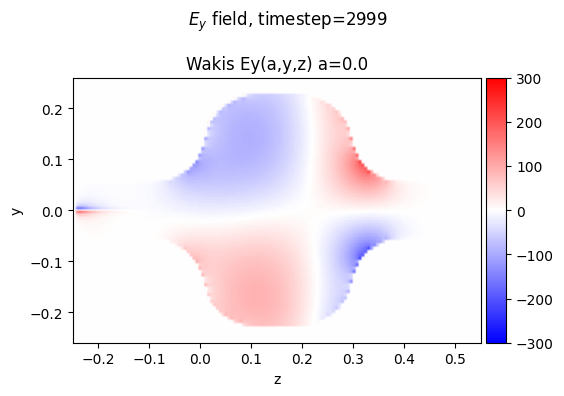

In [22]:
%%px
solver.plot2D(field='E', component='y', 
            plane='YZ', pos=0.5, 
            cmap='bwr', vmin=-300, vmax=300., interpolation='hanning',
            off_screen=False, title=img_folder+'Ez2d', n=n)

[output:0]

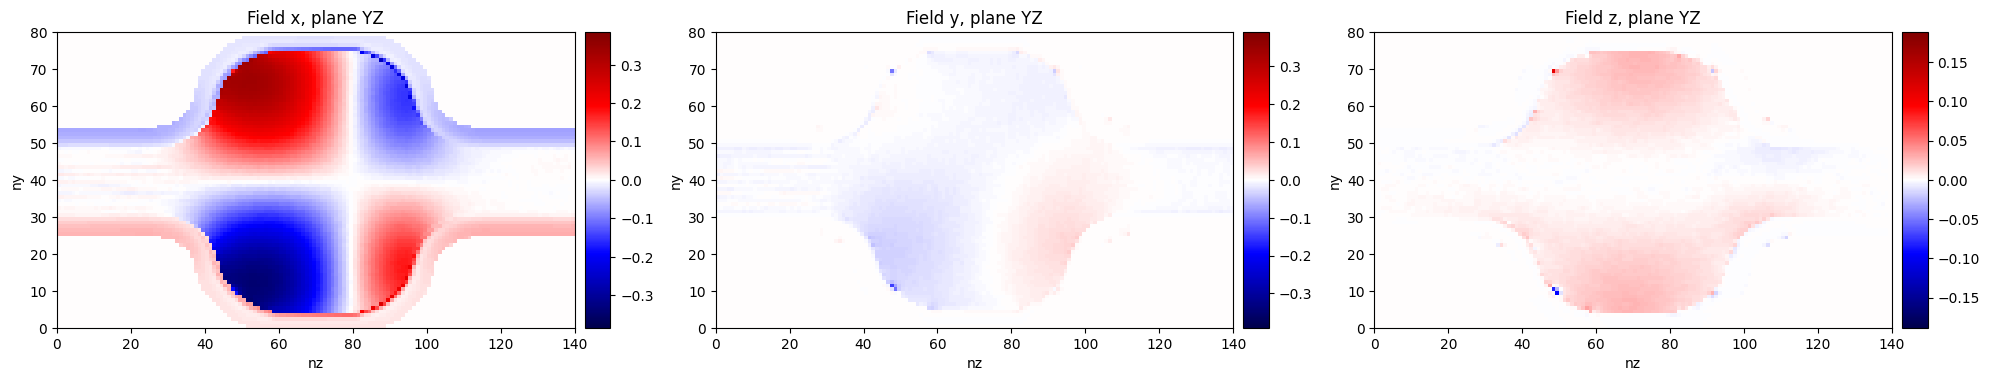

In [32]:
%%px
#gathers H field as a Field object to rank=0
H = solver.mpi_gather_asField('H') 

# only plot in rank 0 where H has been gathered
if rank == 0: 
    fig, ax = H.inspect(figsize=[20,6], cmap='seismic', plane='YZ', show=False, handles=True)
    plt.show()